<a href="https://colab.research.google.com/github/rachelslimovitch/2650-FINAL/blob/main/MNIST_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First: set up packages


In [97]:
install.packages("tensorflow")
install.packages("keras")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [89]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [90]:
library(tensorflow)
library(keras)
library(ggplot2)
library(caret)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:tensorflow’:

    train




## Load in data and pre-process:

In [4]:
#load MNIST data
mnist_data<- dataset_mnist()

In [7]:
#training data
xtrain<-mnist_data$train$x
dim(xtrain) #60,000 x 28 x 28

ytrain<-mnist_data$train$y
dim(ytrain) #60,000

xtest<-mnist_data$test$x
dim(xtest) #10,000 x 28 x 28

ytest<-mnist_data$test$y
dim(ytest) #10,000

[1] 60000    28    28

[1] 60000

[1] 10000    28    28

[1] 10000

In [79]:
#we want pixels to be between [0,1]: normalization helps prevent weights from becoming too large
xtrain<- xtrain / max(xtrain) #dividing by 255
xtest<- xtest / max(xtest) 



	Shapiro-Wilk normality test

data:  xtrain_vec[1, ]
W = 0.481, p-value < 2.2e-16


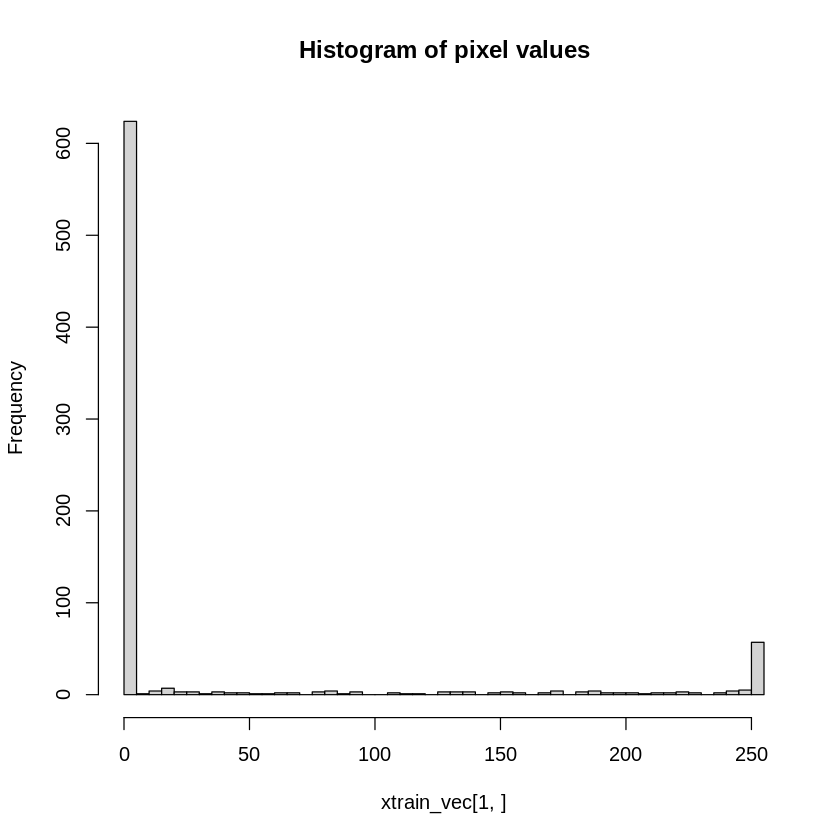

In [14]:
#could also use scale(), if we assume pixel values are ~N. But we can see that ours aren't ~N:

#flatten image shape into vector
xtrain_vec<- array_reshape(xtrain, c(nrow(xtrain), 784)) #b/c 28 * 28 = 784
shapiro.test(xtrain_vec[1,]) #reject null that ~N

hist(xtrain_vec[1,], breaks=50, main="Histogram of pixel values") #definitely not ~N

In [41]:
input_size<- dim(xtrain)[2] * dim(xtrain)[3] #number of rows in each image x number of columns in each image (28 * 28 = 784)
latent_size<- 10 #dimensionality of hidden representation of input layer (10 features represent input data in bottleneck layer)

In [80]:
#reshape matrices to combine row and cols: so # images * # pixels
x_train = array_reshape(xtrain, dim=c(dim(xtrain)[1], input_size))
dim(x_train)

x_test = array_reshape(xtest, dim=c(dim(xtest)[1], input_size))
dim(x_test)

[1] 60000   784

[1] 10000   784

## Define the encoder:

Note that the way we defined our encoder and decoder is slightly different than https://statslab.eighty20.co.za/posts/autoencoders_keras_r/. There, they pass in their encoder as the first layer in their decoder.

In [96]:
#define input layer:
enc_input<-layer_input(shape=c(input_size)) #our input is the 28x28 pixels

#define other layers in encoder:
enc_output = enc_input %>% 
  layer_dense(units=256, activation = "relu") %>% 
  layer_activation_leaky_relu() %>% 
  layer_dense(units=latent_size) %>% #because our latent size is what will be our output of encoder
  layer_activation_leaky_relu()

encoder = keras_model(enc_input, enc_output)
summary(encoder)

Model: "model_5"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_10 (InputLayer)              [(None, 784)]                   0           
 dense_49 (Dense)                   (None, 256)                     200960      
 leaky_re_lu_36 (LeakyReLU)         (None, 256)                     0           
 dense_48 (Dense)                   (None, 10)                      2570        
 leaky_re_lu_35 (LeakyReLU)         (None, 10)                      0           
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
________________________________________________________________________________


Note- 
I tried to run this the way we had been, and the input layer wouldn't show up in the summary. I also learned that the input layer doesn't go into Keras. Is there a reason why we need to do it this way?

## Define the decoder: 
The decoder goes from the bottleneck to the reconstructed input. 

Note that we use sigmoid as the activation function in the final layer decoder because this is the range of pixels in the MNIST data (we normalized the pixels to be between 0 and 1 instead of 0 and 255).

**QUESTION:** do we need to use a leaky_relu layer? If so... should this be 0?

In [55]:
dec_input = layer_input(shape = latent_size) #our input is that latent size

dec_output = dec_input %>% 
  layer_dense(units=256, activation = "relu") %>% 
  layer_activation_leaky_relu() %>% 
  layer_dense(units = input_size, activation = "sigmoid") %>%  #our output is the original input, and sigmoid b/c forces output to be between 0 and 1
  layer_activation_leaky_relu()

decoder = keras_model(dec_input, dec_output)
 
summary(decoder)

Model: "model_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_5 (InputLayer)               [(None, 10)]                    0           
 dense_41 (Dense)                   (None, 256)                     2816        
 leaky_re_lu_28 (LeakyReLU)         (None, 256)                     0           
 dense_40 (Dense)                   (None, 784)                     201488      
 leaky_re_lu_27 (LeakyReLU)         (None, 784)                     0           
Total params: 204,304
Trainable params: 204,304
Non-trainable params: 0
________________________________________________________________________________


## Define the autoencoder

We need to combine our encoder and decoder, while using an additional input layer (into the encoder). 

In [56]:
aen_input = layer_input(shape = input_size) #original input: 28x28

aen_output = aen_input %>% #original input
  encoder() %>%  #encoder
  decoder() #decoder
   
aen = keras_model(aen_input, aen_output)
summary(aen)

Model: "model_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_6 (InputLayer)               [(None, 784)]                   0           
 model (Functional)                 (None, 10)                      203530      
 model_1 (Functional)               (None, 784)                     204304      
Total params: 407,834
Trainable params: 407,834
Non-trainable params: 0
________________________________________________________________________________


**QUESTION:** the website used binary_crossentropy instead of mse. But we don't have binary inputs: we have inputs that range from 0 to 1. 
However, when I tried to run the images, I found that binary_crossentropy produced reconstructed images that made sense, while mse produced a white cloud for each image. 

NOTE: reason why x_train is both the x and y is because the input data is used as both the input and target output during training. The model learns to encode the input data into a compressed representation and then decode this representation to reconstruct the original input data as closely as possible.

In [83]:
#NOTE: this takes ~4min to run
#Fitting the model
aen %>% compile(
  optimizer = 'adam',  #note that the website used rmsprop instead, could choose either
  loss = 'binary_crossentropy', #the website used binary_crossentropy
)

#Train the model:
aen %>% fit(x= x_train,
            y= x_train,  #b/c in autoencoders, goal is to reconstruct input
            epochs=50, 
            batch_size=256)

## Generate the autoencoder:
We can generate x_test data using the encoder and decoder.

First: encode and then decode the data. 

In [84]:
#encode
encoded_imgs <- encoder %>% 
                predict(x_test) #predicting on x_test

In [85]:
#decoder
decoded_imgs<- decoder %>%
               predict(encoded_imgs) #predicting on the output of the encoder
             

In [86]:
#change shape of the decoded data: back to 10,000 x 28 x 28, currently 10,000 x 784
pred_images = array_reshape(decoded_imgs, dim=c(dim(decoded_imgs)[1], 28, 28))

## visualize the original x test images and the reconstructed images:

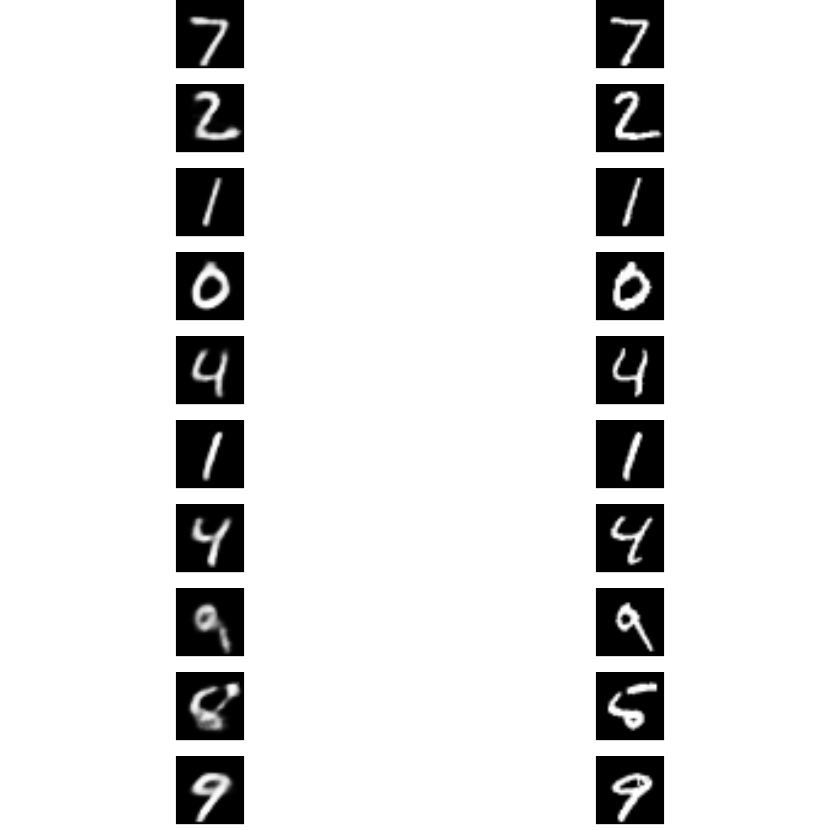

In [87]:
op <- par(mfrow=c(10,2), mar=c(1,0,0,0)) #setup: 12 images in each of 2 columns

#loop through 1-10:
for (i in 1:10){
  plot(as.raster(pred_images[i,,]))
  plot(as.raster(xtest[i,,]))
}



---



## We can look at anomaly detection:
*Question: is this basically just finding outliers?*

We can use the reconstruction error as an anomaly score.

1) Train our autoencoder on MNISt using x_train as input and output (as we did above)

2) Use trained autoencoder to predict reconstructed output on MNIST test data using x_test (which we did above)

3) Calculate the MSE between x_test (original test images) and the reconstructed version. We'll use keras::mse()

4) Visualize the distribution of the MSE by using a histogram or density. If distribution is bimodal/has a long tail: indicates presence of anomalies.

5) To identify images that are anomalies: set a threshold for MSE scores. Images with MSE higher than threshold: flagged as anomalies.

## We can do denoising:



## Next: we can visualize the embedding.
In the petal length code, they had 2 variables they were comparing: petal length and sepal width. 

In our code, it will be similar to Wk5 when we had the faces (Wk4/Wk5). 

Instead of the x-axis being petal length and the y-axis being sepal width, we'll use pixel values of the images. So each image will be a point on the plot, and the x-value of the coordinates will represent pixel values in the x-direction of the image, and the y-value of the coordinate will represent pixel values in the y-direction of the image (**???does this make sense??**)

https://ranasinghiitkgp.medium.com/principal-component-analysis-pca-with-code-on-mnist-dataset-da7de0d07c22
(MNIST is already pretty low dimensional, with only 784 features)

## To compare to PCA:
We will just use our encoder, and we'll compare our latent layer to PCA. We can do this visually or we can compare the accuracy of the two models.

************************

---



Note: to understand the code from https://statslab.eighty20.co.za/posts/autoencoders_keras_r/, I read in the data. 

In [91]:
split_ind <- iris$Species %>% caret::createDataPartition(p = 0.8,list = FALSE)

train <- iris[split_ind,]
test <- iris[-split_ind,]

#data has 5 variables: sepal length, sepal width, petal length, petal width, species